# HR-Capstone-Analysis

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



# Functions

In [66]:
def check_for_nulls_dupes(df):
  print(f"The amount of Null Values: {df.isna().sum()}")
  print(f"The amount of Duplicated Values {df.duplicated().sum()}")

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.show()

def plot_distribution(df, kind):
  
  plt.figure(figsize=(16,16))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(df.columns):
    if col == "Type":
      continue
    plt.subplot(rows ,4, idx+1)
    sns.histplot(df[col], kde=True) if kind == "hist" else plt.boxplot(df[col])
    plt.title(f"Distribuition of {col}")
    plt.ylabel("Counts")

  plt.tight_layout()
  plt.show()

def dist_plot(df):
  
  for col in df.columns:
    salary_skewness = df[col].skew()
    salary_kurtosis = df[col].kurtosis()

    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, color='blue')
    plt.title(f'Distribution of {col} with Skewness and Kurtosis')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    plt.text(x=0.95, y=0.85, s=f"Skewness: {salary_skewness:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')
    plt.text(x=0.95, y=0.80, s=f"Kurtosis: {salary_kurtosis:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')

    plt.grid(True)
    plt.show()

def aggregate_dataset(df, interested_columns, agg_col, function):
  
  plt.figure(figsize=(12,12))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == agg_col:
      continue
    plt.subplot(rows ,4, idx+1)
    grouped_df = getattr(df.groupby(agg_col)[col], function)().reset_index(name=col)
    sns.barplot(data=grouped_df, x=agg_col, y=col)
    plt.title(f"Agg of {col}")
    plt.ylabel(col)
    plt.xticks(rotation =45)
  plt.tight_layout()
  plt.show()

def scatter_plot(df, interested_columns, target):
  
  plt.figure(figsize=(12,10))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == target:
      continue
    plt.subplot(rows ,3, idx+1)
    sns.scatterplot(data=df, x=target, y=col, hue=col)
  plt.tight_layout()
  plt.show()

def aggregate_salaries(df):
  
  department_columns = df["Department"].unique()

  metric_tracker = []
  for col in department_columns:
    print(f"Col: {col}")
    row = df[df["Department"] == col]
    
    avg_monthly_hours =  row["average_montly_hours"].mean()
    total_hours = row["average_montly_hours"].sum()
    
    total_turnover = row["left"].sum()
    num_promotions = row["promotion_last_5years"].sum()
    
    mean_years_at_company = row["time_spend_company"].mean()
    sum_years_at_company = row["time_spend_company"].sum()
    
    mean_projects= row["number_project"].mean()
    sum_projects = row["number_project"].sum()
    
    mean_satisfaction_level = row["satisfaction_level"].mean()
    total_satisfaction_level = row["satisfaction_level"].sum()
    
    mean_evaluation = row["last_evaluation"].mean()
    sum_evaluation = row["last_evaluation"].sum()
    
    metric_tracker.append(
      {
        "avg_monhtly_hours": avg_monthly_hours,
        "total_hours": total_hours,
        "total_turnover":total_turnover,
        "num_promotions": num_promotions,
        "mean_years_at_company":mean_years_at_company,
        "sum_years_at_company":sum_years_at_company,
        "mean_projects":mean_projects,
        "sum_projects":sum_projects,
        "mean_statisfaction_level":mean_satisfaction_level,
        "total_satisfaction_level":total_satisfaction_level,
        "mean_evaluation":mean_evaluation,
        "sum_evaluation":sum_evaluation
      }
    )
  
  return pd.DataFrame(metric_tracker)

# EDA Analysis

In [2]:
df = pd.read_csv("/Users/maukanmir/Downloads/data.csv")
df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


# Check For Nulls And Dupes

In [4]:
check_for_nulls_dupes(df)

The amount of Null Values: satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
dtype: int64
The amount of Duplicated Values 3008


In [5]:
df.drop_duplicates(inplace=True)

# Check Class Imbalance

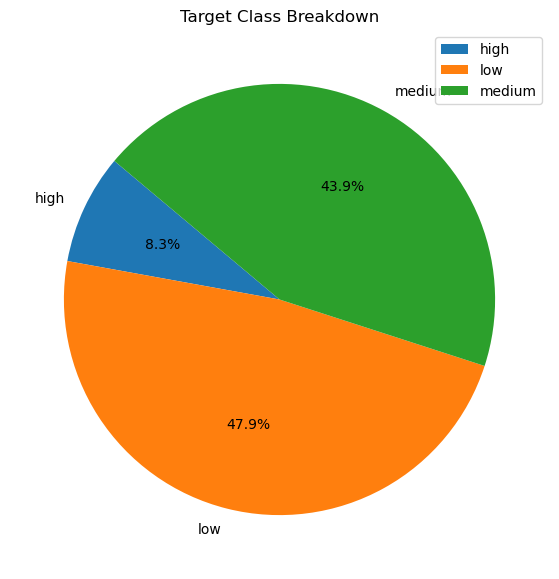

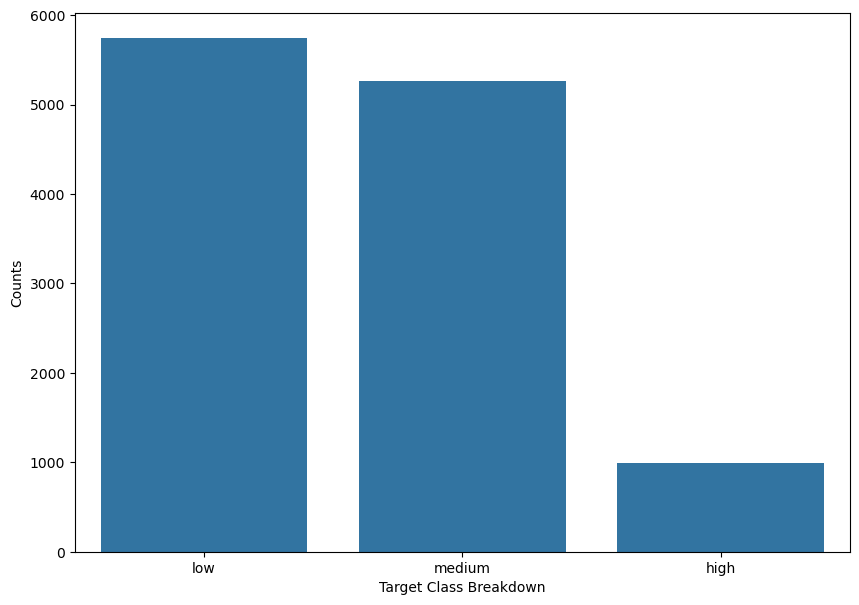

In [6]:
check_class_imbalance(df["salary"])

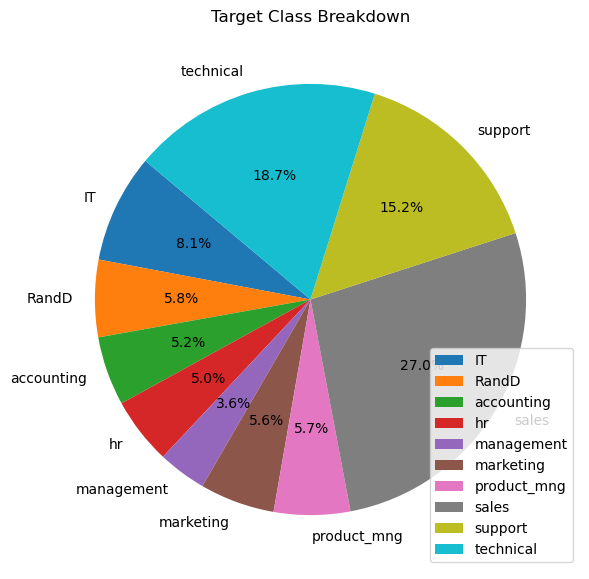

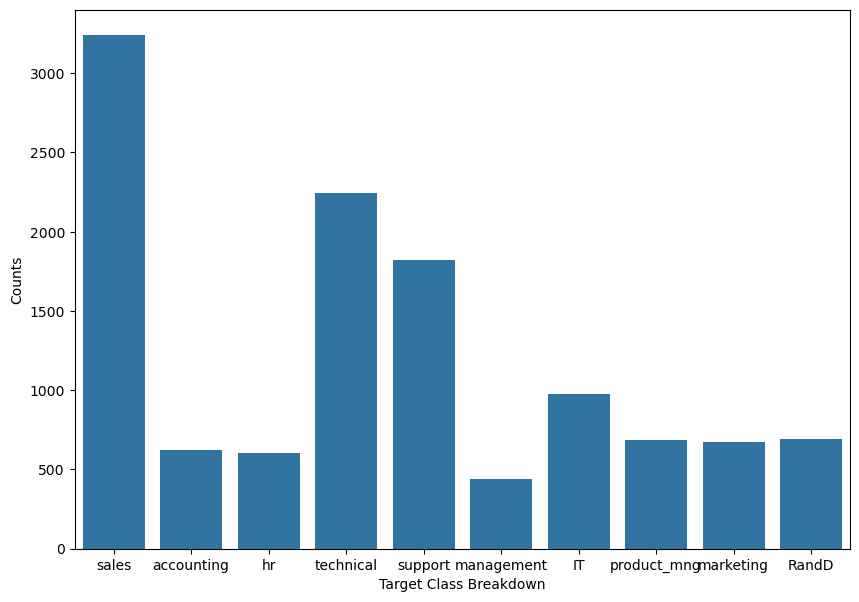

In [7]:
check_class_imbalance(df["Department"])

In [8]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000
mean,0.629658,0.716683,3.802852,200.473522,3.364857,0.154282,0.166041,0.016929
std,0.241070,0.168343,1.163238,48.727813,1.330240,0.361234,0.372133,0.129012
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.480000,0.570000,3.000000,157.000000,3.000000,0.000000,0.000000,0.000000
50%,0.660000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.860000,5.000000,243.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [10]:
df.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
Department                object
salary                    object
dtype: object

In [9]:
numeric_types = df.select_dtypes(exclude=["object"])
categorical_types = df.select_dtypes(include=["object"])

In [12]:
heat_map_df = df.copy()
heat_map_df["salary"] = heat_map_df["salary"].apply(lambda x: 0 if x == "low" else 1 if x == "medium" else 2)

# Heat Map

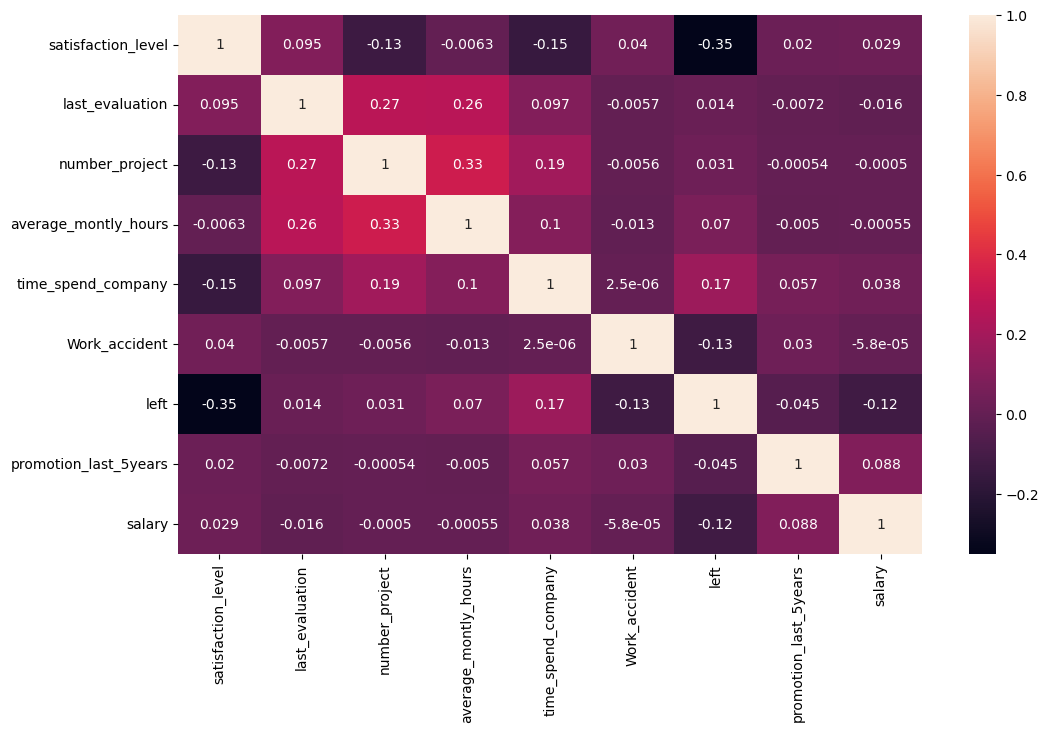

In [13]:
relations = heat_map_df.select_dtypes(exclude="object").corr()
plt.figure(figsize=(12, 7))
sns.heatmap(data=relations, annot=True)
plt.show()

# Distributions

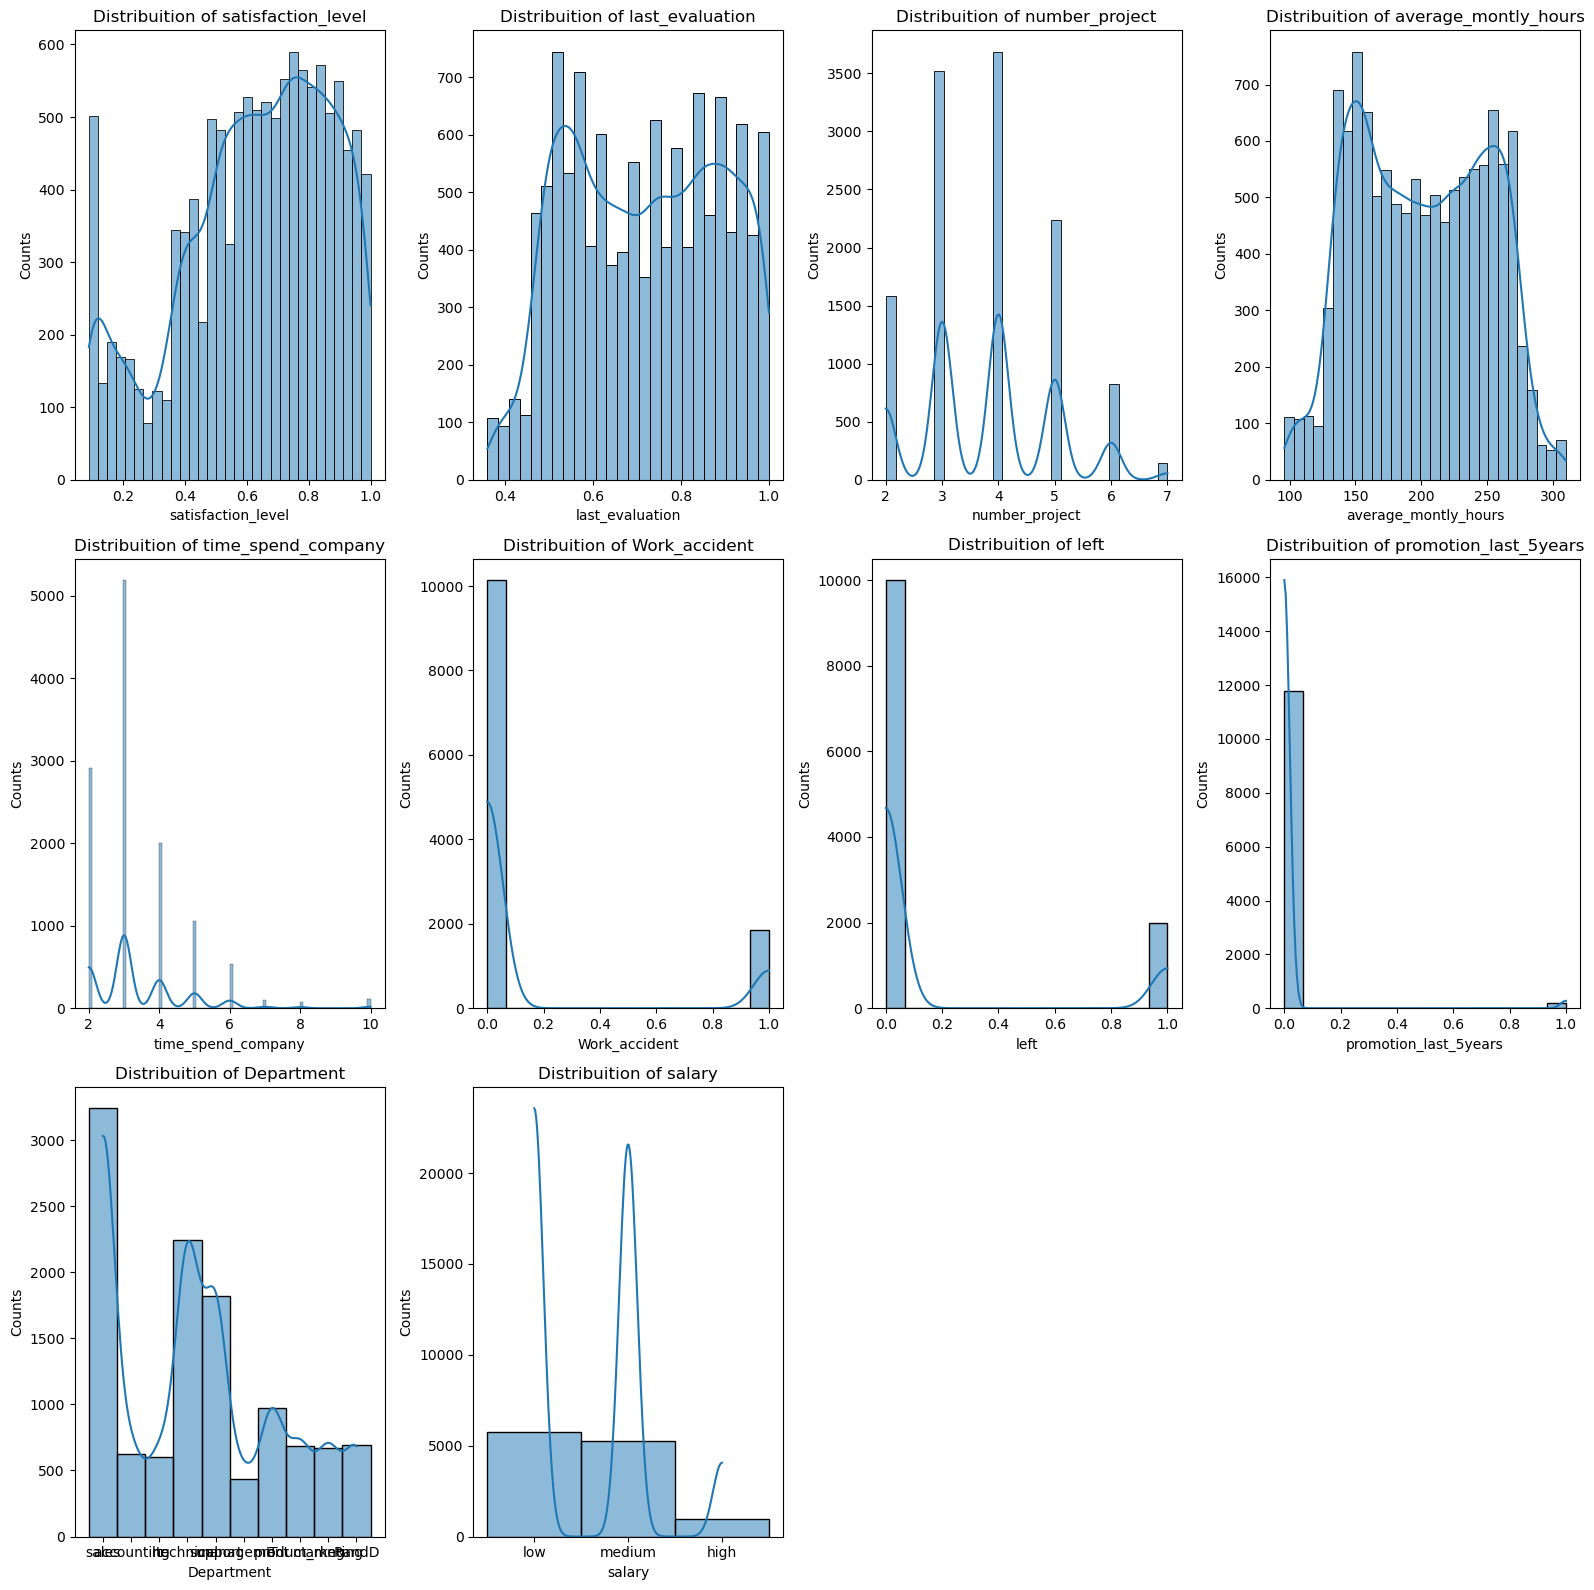

In [15]:
plot_distribution(df, "hist")

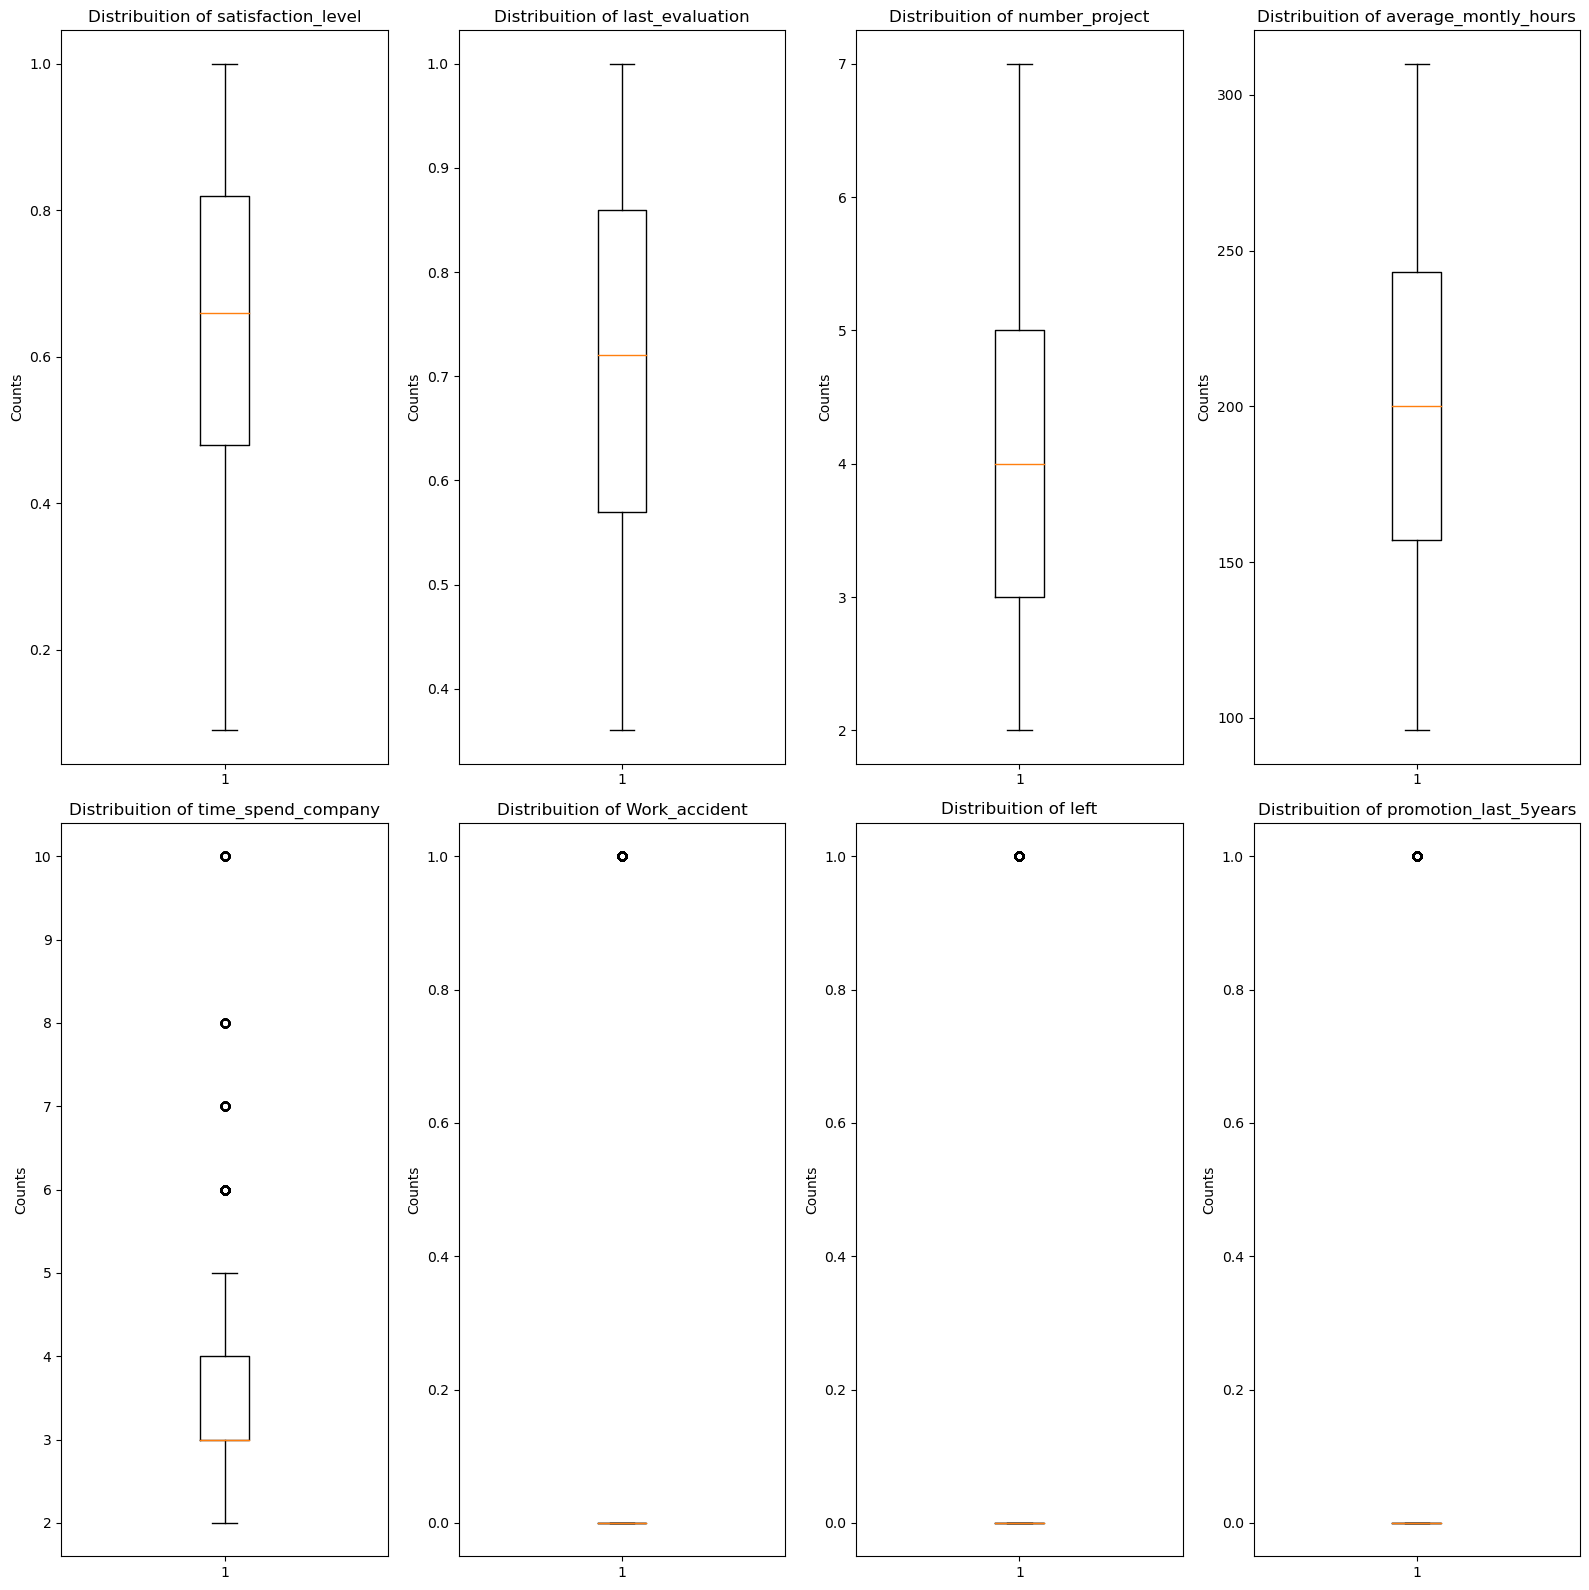

In [17]:
plot_distribution(numeric_types, "box")

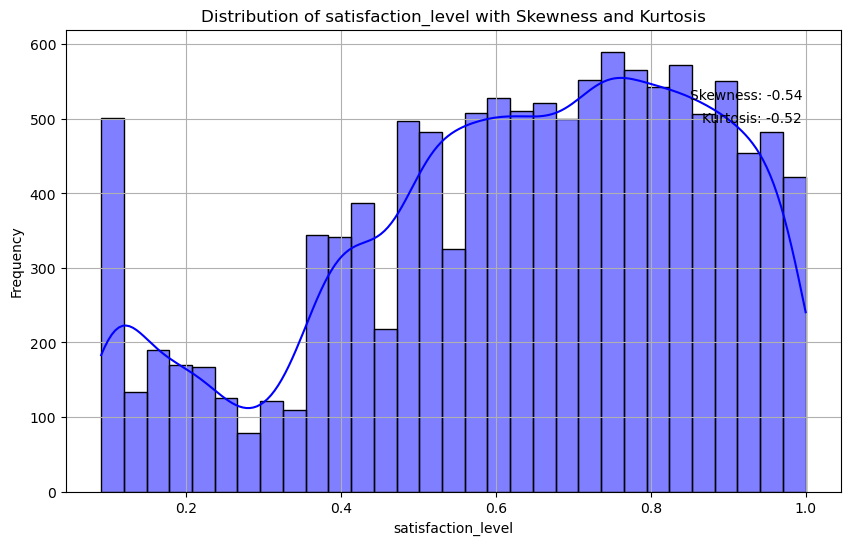

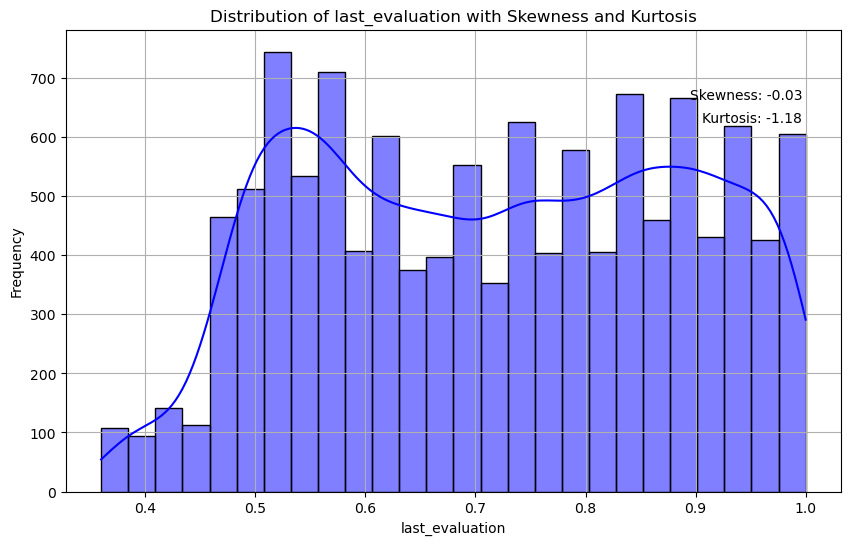

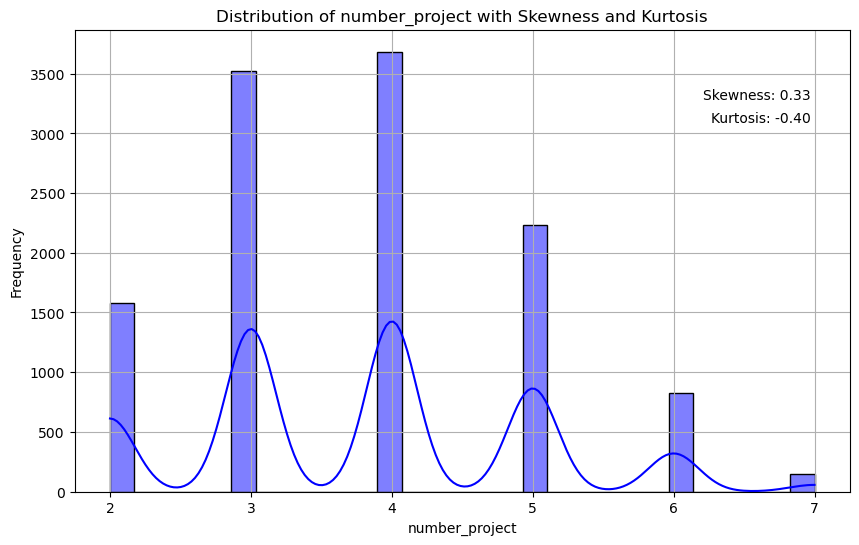

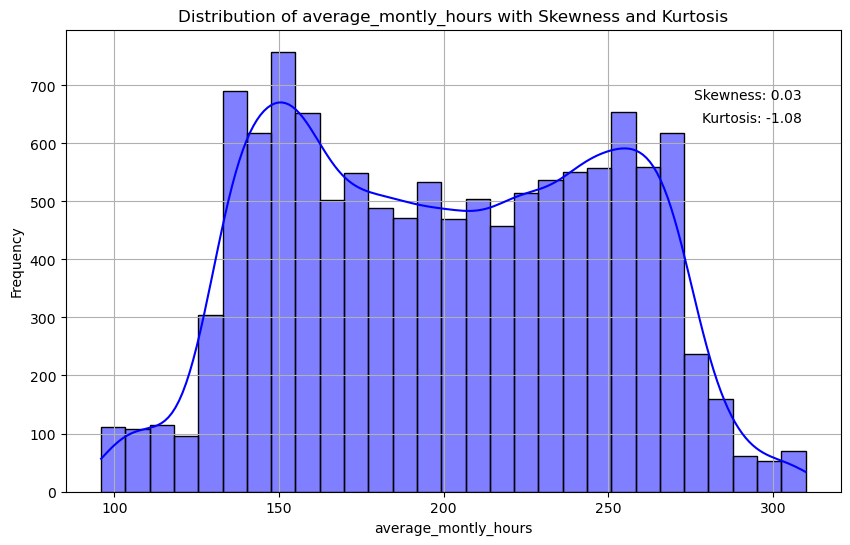

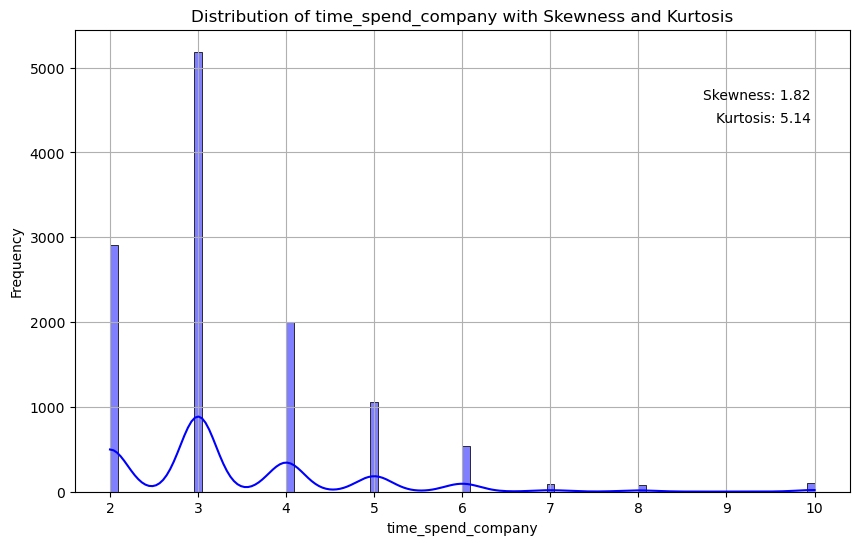

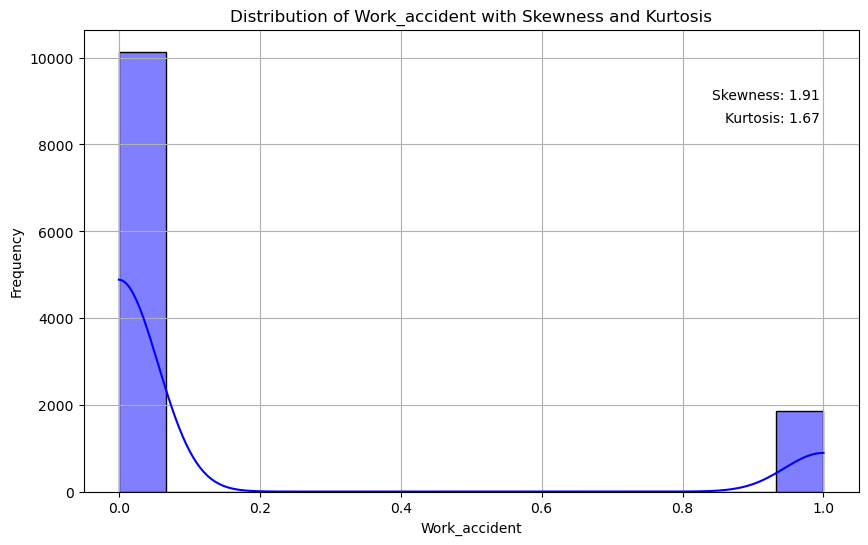

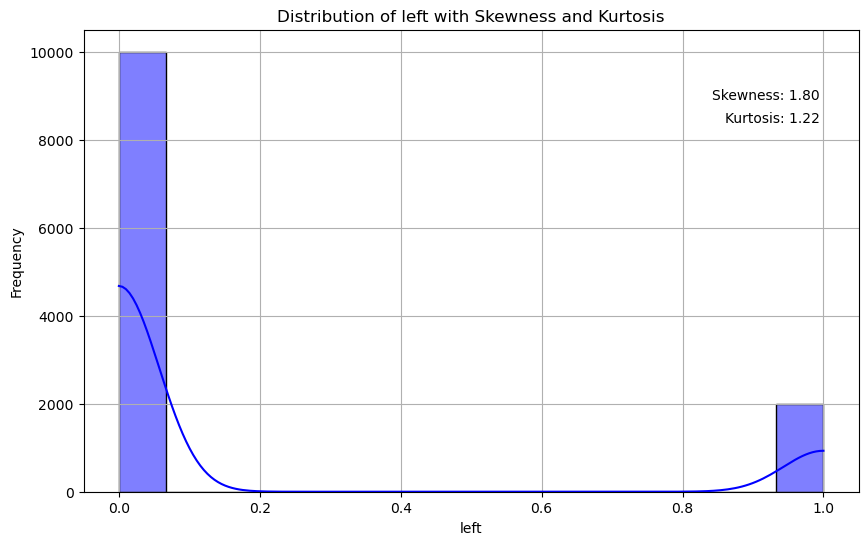

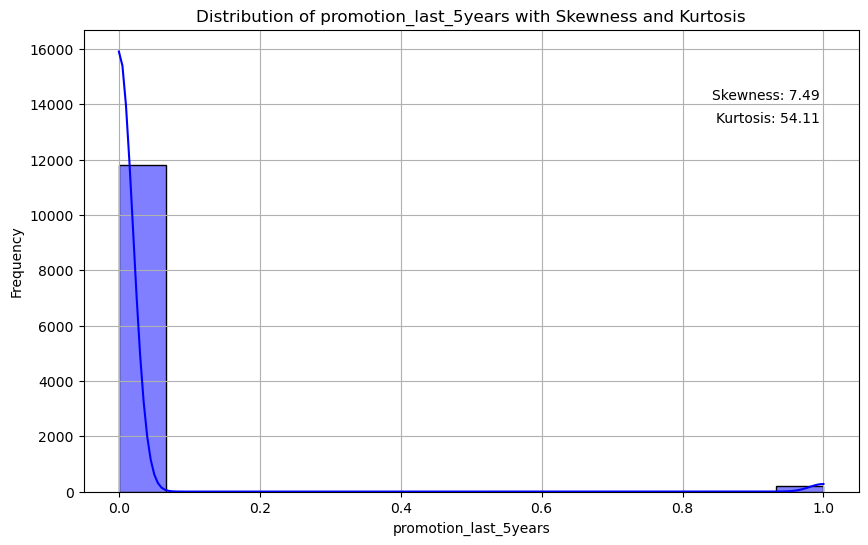

In [19]:
dist_plot(numeric_types)

# Aggregated Views

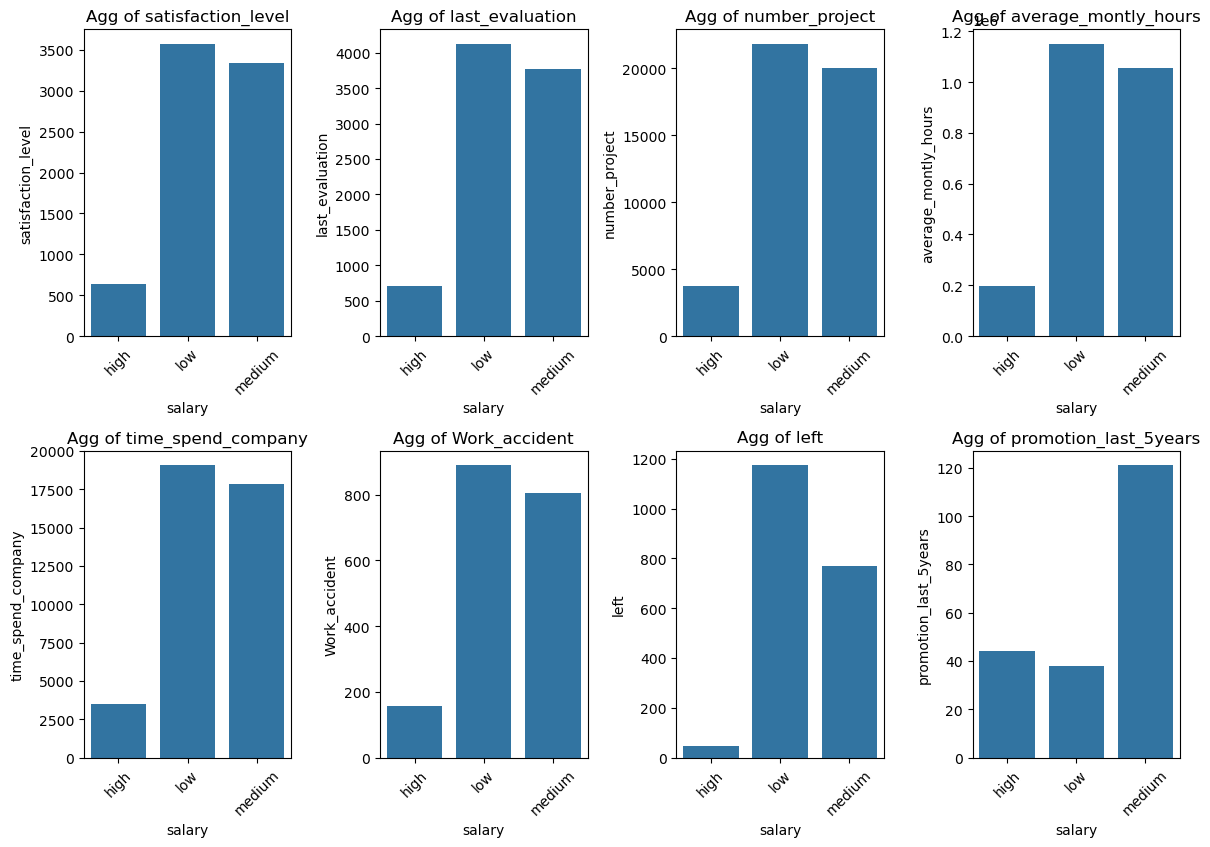

In [22]:
aggregate_dataset(df, numeric_types.columns, "salary", "sum")

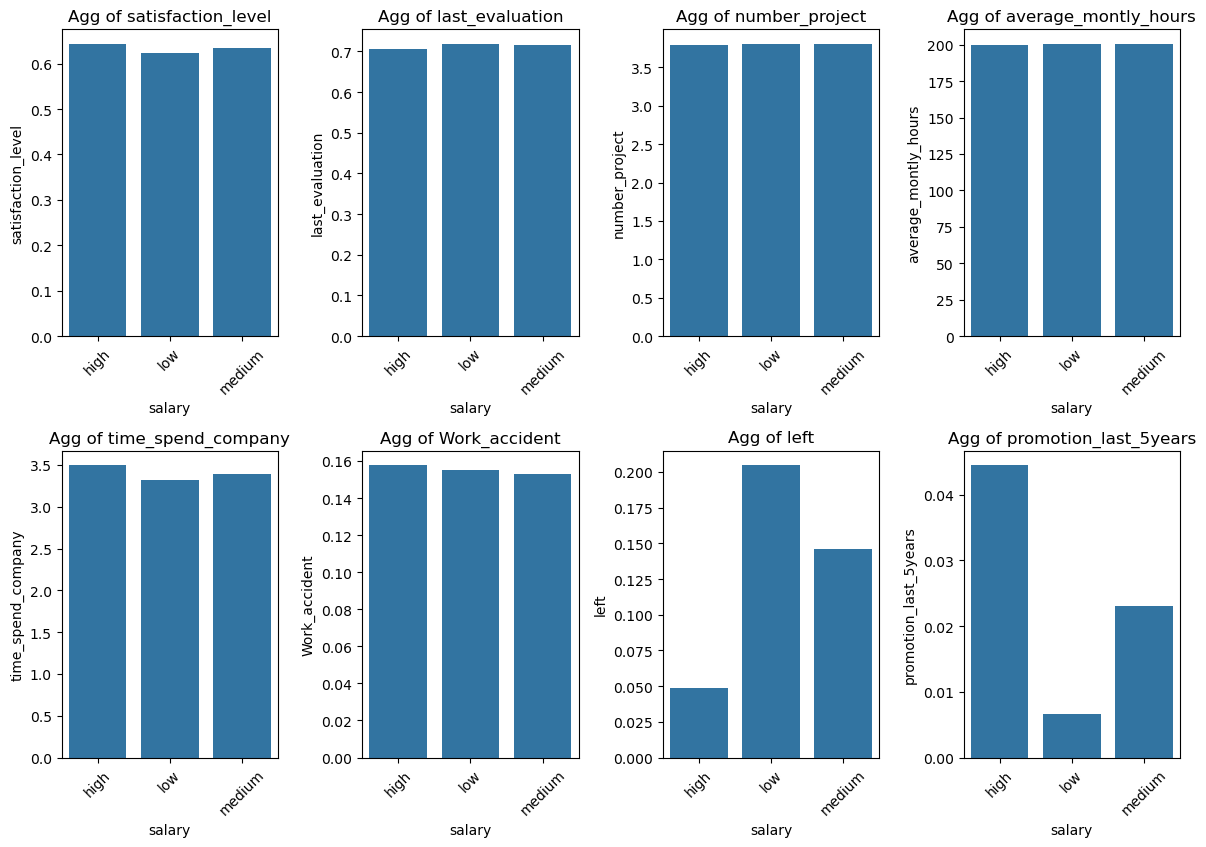

In [23]:
aggregate_dataset(df, numeric_types.columns, "salary", "mean")

# Scatter Plots

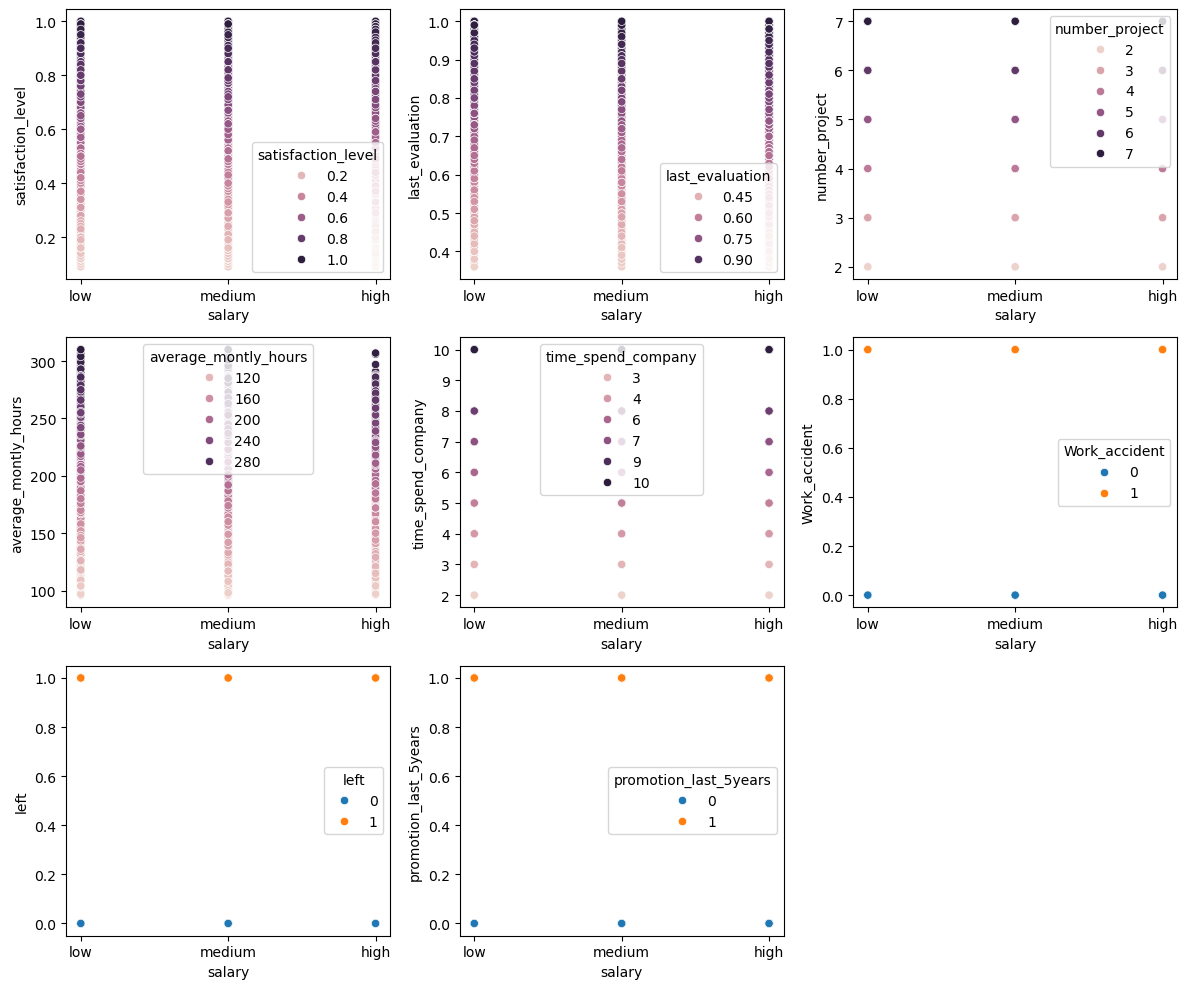

In [25]:
scatter_plot(df, numeric_types.columns, "salary")

# Highest Paid Salaries By Profession

In [27]:
highest_paid = df[df["salary"] == "high"]

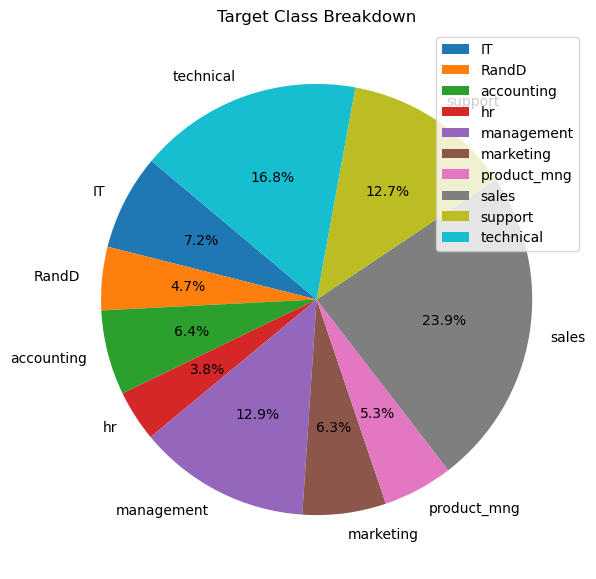

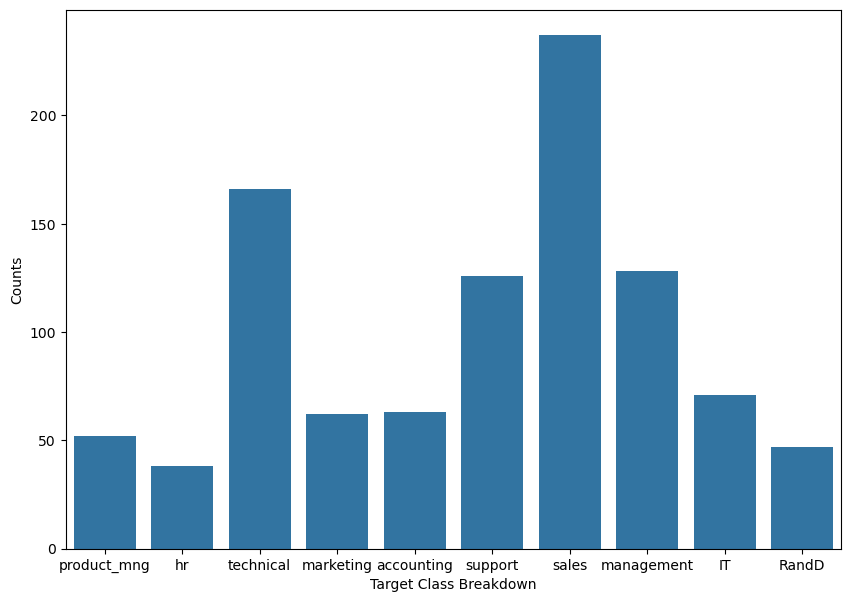

In [30]:
check_class_imbalance(highest_paid["Department"])

# Hightest Paid Earners Who Left The Company

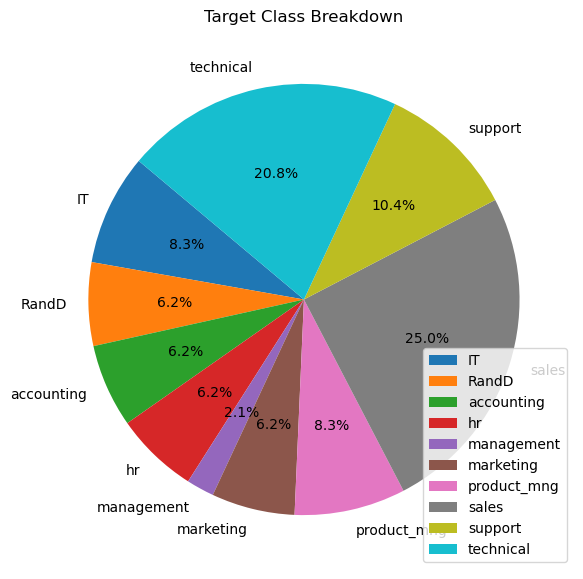

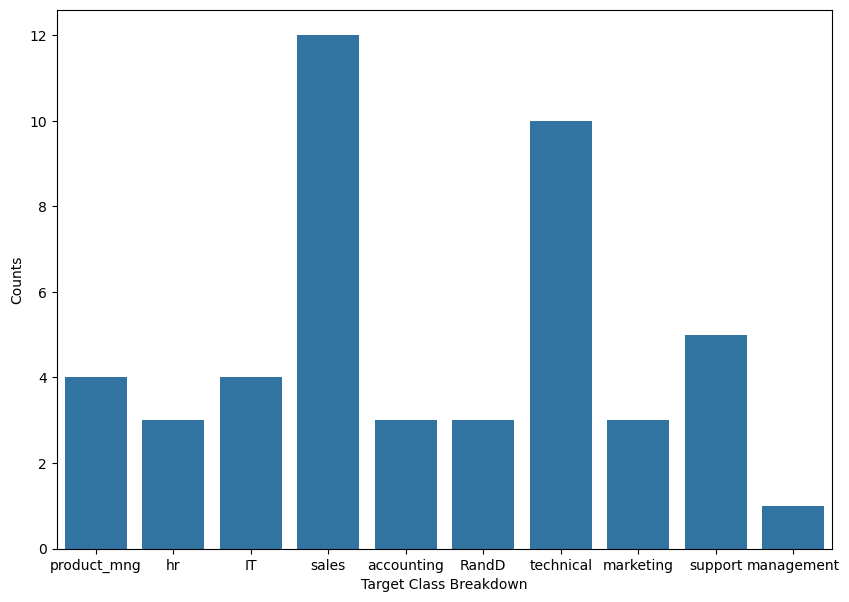

In [67]:
highest_paid_left = highest_paid[highest_paid["left"] ==1]
check_class_imbalance(highest_paid_left["Department"])

# Highest Paid Aggregate Stats

In [31]:
highest_paid.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000
mean,0.643343,0.706838,3.791919,200.067677,3.493939,0.157576,0.048485,0.044444
std,0.226611,0.158864,1.063759,47.477252,1.713995,0.364527,0.214897,0.206185
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.510000,0.570000,3.000000,161.250000,2.000000,0.000000,0.000000,0.000000
50%,0.660000,0.710000,4.000000,201.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.840000,5.000000,241.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,307.000000,10.000000,1.000000,1.000000,1.000000


# Medium Paid Earners 

In [68]:
medium_paid = df[df["salary"] == "medium"]
medium_paid.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,5261.000000,5261.000000,5261.000000,5261.000000,5261.000000,5261.000000,5261.00000,5261.000000
mean,0.634723,0.716539,3.806121,200.587341,3.389850,0.153013,0.14617,0.022999
std,0.237343,0.168320,1.140529,48.371399,1.363666,0.360034,0.35331,0.149916
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.00000,0.000000
25%,0.490000,0.570000,3.000000,157.000000,3.000000,0.000000,0.00000,0.000000
50%,0.660000,0.720000,4.000000,201.000000,3.000000,0.000000,0.00000,0.000000
75%,0.820000,0.860000,5.000000,243.000000,4.000000,0.000000,0.00000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.00000,1.000000


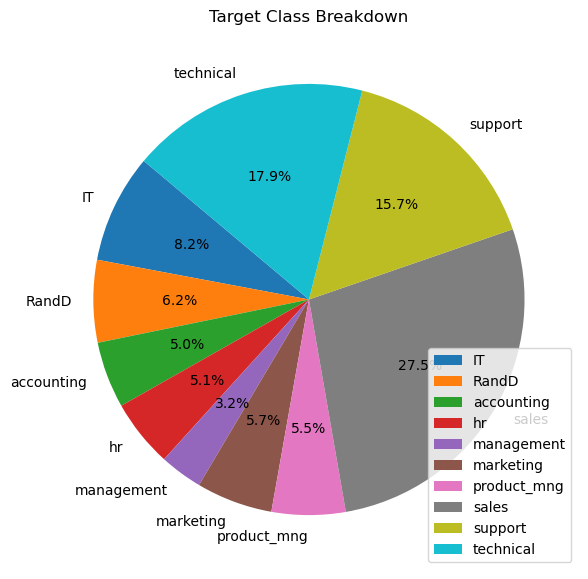

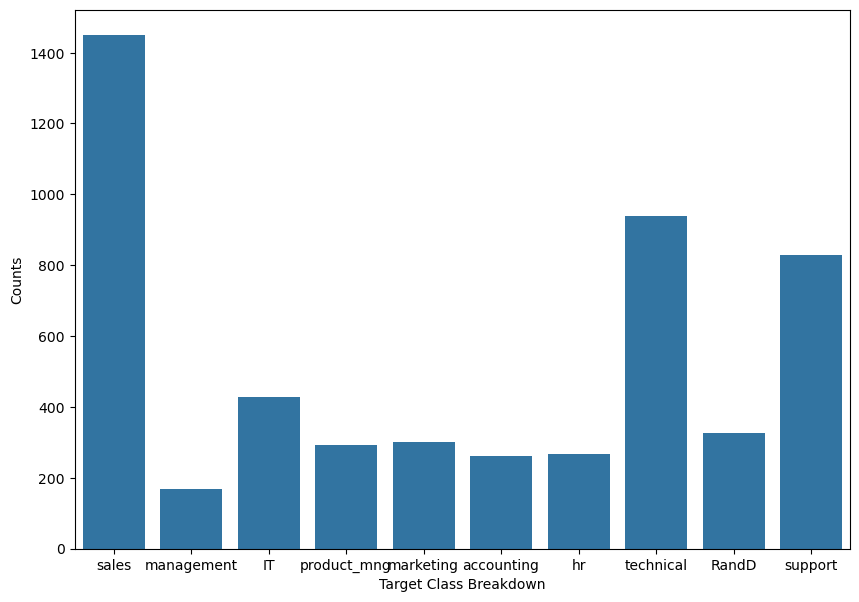

In [69]:
check_class_imbalance(medium_paid["Department"])

# Medium Paid Earners Who Left the Company

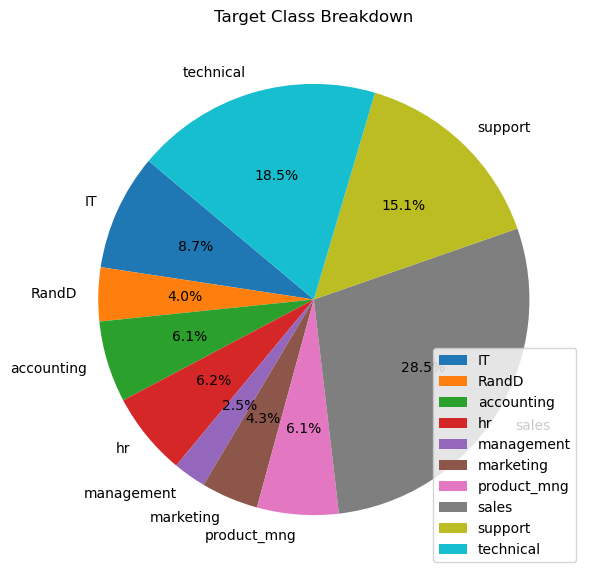

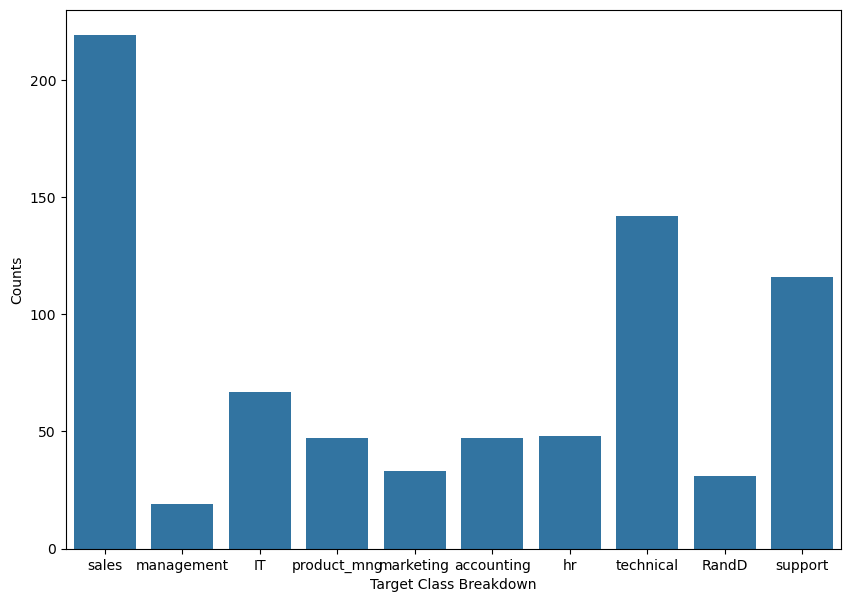

In [76]:
medium_paid_left = medium_paid[medium_paid["left"] == 1]
check_class_imbalance(medium_paid_left["Department"])

# Lowest Paid

In [72]:
lowest_paid = df[df["salary"] == "low"]
lowest_paid.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,5740.000000,5740.000000,5740.000000,5740.000000,5740.000000,5740.000000,5740.000000,5740.000000
mean,0.622655,0.718512,3.801742,200.439199,3.319686,0.154878,0.204530,0.006620
std,0.246637,0.169913,1.199871,49.271065,1.216886,0.361820,0.403393,0.081102
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.450000,0.570000,3.000000,157.000000,3.000000,0.000000,0.000000,0.000000
50%,0.650000,0.720000,4.000000,199.000000,3.000000,0.000000,0.000000,0.000000
75%,0.830000,0.870000,5.000000,244.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


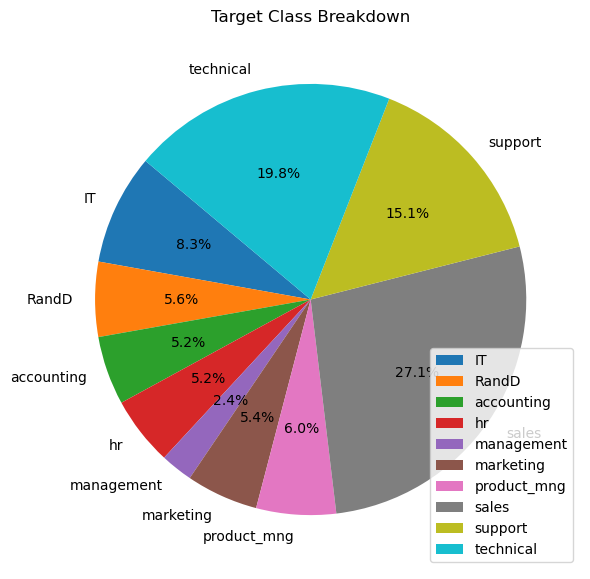

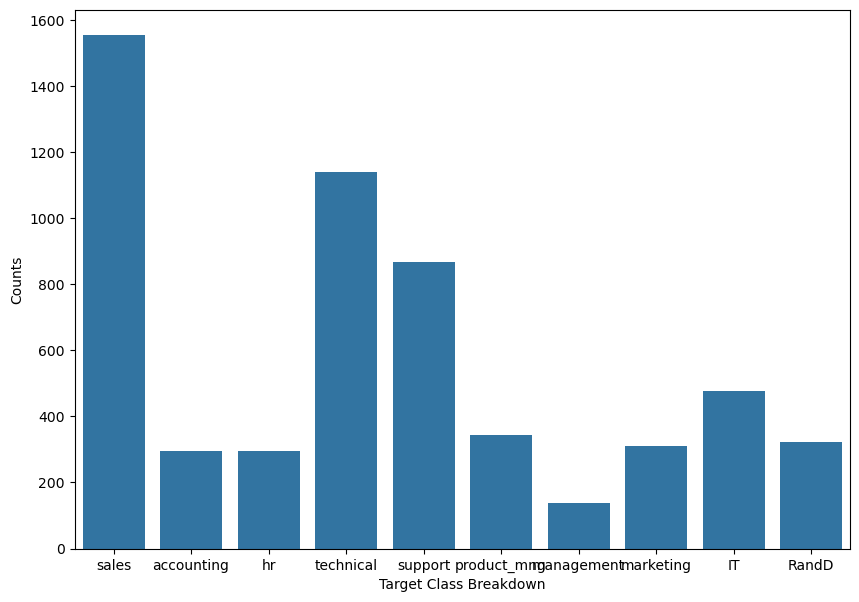

In [74]:
check_class_imbalance(lowest_paid["Department"])

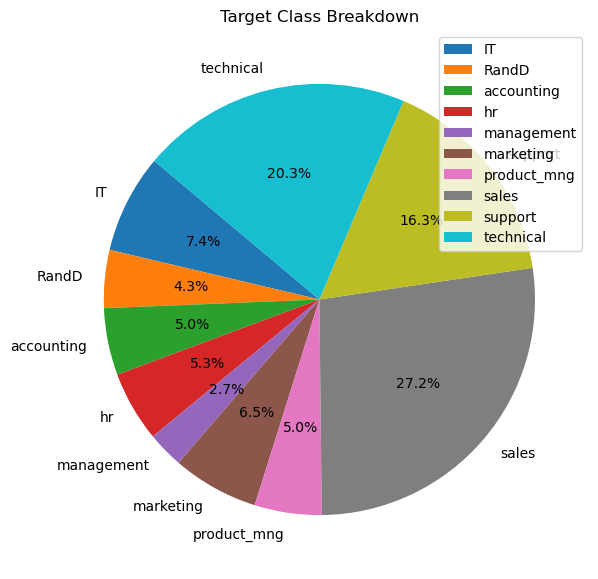

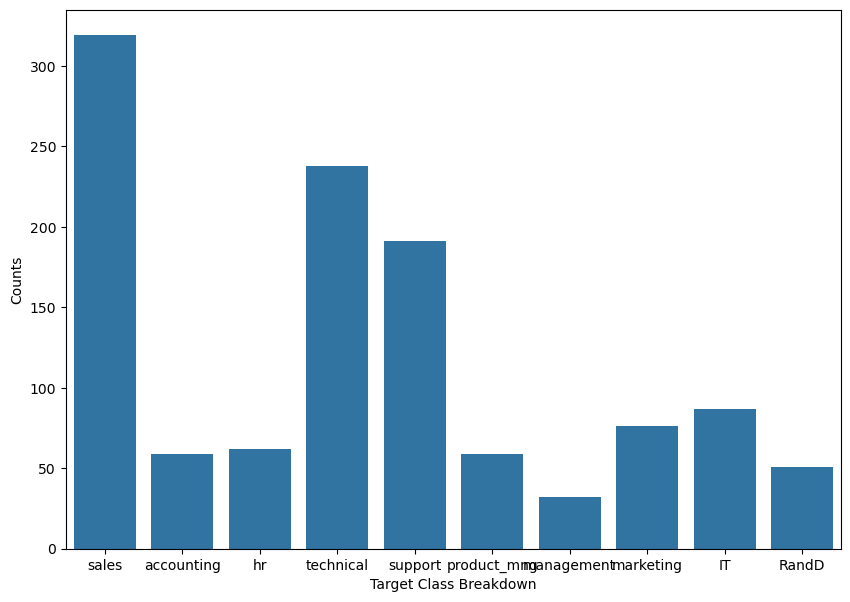

In [75]:
lowest_paid_left = lowest_paid[lowest_paid["left"] ==1]
check_class_imbalance(lowest_paid_left["Department"])

# Average Stats based on department

In [64]:
department_columns = highest_paid["Department"].unique()

metric_tracker = []
for col in department_columns:
  print(f"Col: {col}")
  row = highest_paid[highest_paid["Department"] == col]
  
  avg_monthly_hours =  row["average_montly_hours"].mean()
  total_hours = row["average_montly_hours"].sum()
  
  total_turnover = row["left"].sum()
  num_promotions = row["promotion_last_5years"].sum()
  
  mean_years_at_company = row["time_spend_company"].mean()
  sum_years_at_company = row["time_spend_company"].sum()
  
  mean_projects= row["number_project"].mean()
  sum_projects = row["number_project"].sum()
  
  mean_satisfaction_level = row["satisfaction_level"].mean()
  total_satisfaction_level = row["satisfaction_level"].sum()
  
  mean_evaluation = row["last_evaluation"].mean()
  sum_evaluation = row["last_evaluation"].sum()
  
  metric_tracker.append(
    {
      "avg_monhtly_hours": avg_monthly_hours,
      "total_hours": total_hours,
      "total_turnover":total_turnover,
      "num_promotions": num_promotions,
      "mean_years_at_company":mean_years_at_company,
      "sum_years_at_company":sum_years_at_company,
      "mean_projects":mean_projects,
      "sum_projects":sum_projects,
      "mean_statisfaction_level":mean_satisfaction_level,
      "total_satisfaction_level":total_satisfaction_level,
      "mean_evaluation":mean_evaluation,
      "sum_evaluation":sum_evaluation
    }
  )



Col: product_mng
Col: management
Col: sales
Col: accounting
Col: hr
Col: IT
Col: RandD
Col: marketing
Col: technical
Col: support


In [65]:
highest_paid

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
72,0.45,0.49,2,149,3,0,1,0,product_mng,high
9315,0.91,0.52,4,172,4,1,0,0,management,high
9336,0.97,0.66,4,218,3,0,0,0,sales,high
9337,0.61,0.59,3,157,2,0,0,0,sales,high
9340,0.77,0.73,5,263,2,0,0,0,accounting,high
...,...,...,...,...,...,...,...,...,...,...
5904,0.74,0.48,5,165,2,0,0,0,sales,high
5943,0.68,0.92,3,226,2,0,0,0,IT,high
5982,0.17,0.73,4,274,3,0,0,0,accounting,high
5983,0.84,0.61,4,261,2,0,0,0,accounting,high


# 